In [1]:
# ── Colab: one-off installs ────────────────────────────────────────────────
!pip install --quiet openai==1.* umap-learn pandas matplotlib

# ── Imports & keys ─────────────────────────────────────────────────────────
import os, json, time, numpy as np, pandas as pd, matplotlib.pyplot as plt
import openai, umap



In [ ]:
# 1️⃣  Add your key safely (use colab secrets or env var in production)
openai.api_= "OpenAI key"                     #  <-- replace, or os.getenv("OPENAI_API_KEY")

BASE_MODEL   = "gpt-4o-mini-2024-07-18"
TUNED_MODEL  = "model_key"
EMBED_MODEL  = "text-embedding-3-large"       # cheaper: "...-small"


In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
# Option A: use your existing test CSV
test = pd.read_csv("/content/drive/MyDrive/AI_Humanities/final_project/final_project/data/fortune_test.csv").sample(15, random_state=42)

# Option B: quick manual list (uncomment to use)
# test = pd.DataFrame({"question": [
#     "Is 8 August an auspicious wedding date?",
#     "What crystal promotes better focus at work?",
#     "How can I improve energy flow in a north-facing apartment?"
# ]})

test.head(3)


,question,answer,Complex_CoT
25,请帮我看看我的家庭运势。,"【家庭运势解读与指引】\n\n❶ 能量场扫描\n星盘显示家宅宫位有""天贵""与""红鸾""同现，主...",好的，用户发来了一个请求，内容是查看家庭运势。首先，我需要确定用户的需求是什么。家庭运势通常...
13,属蛇的人今年适合结婚吗？,"{\n ""answer"": ""2023年对于属蛇的朋友而言，感情宫有【天喜】吉星入命，此星...",好的，用户问的是属蛇的人今年是否适合结婚。首先，我需要确定今年的具体年份，因为不同的年份对应...
8,想请问一下结婚的良辰吉日该如何选择？,关于婚嫁择日的选择，中国传统文化中有一套严谨的择吉体系。以下是专业建议：\n\n一、核心原则...,好的，用户问的是如何选择结婚的良辰吉日。首先，我需要回忆一下中国传统文化中关于婚嫁择日的习俗...


In [6]:
def chat(model, prompt, temperature=0):
    """Single synchronous chat request."""
    res = openai.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        temperature=temperature
    )
    return res.choices[0].message.content.strip()

# ── Loop through prompts once per model ────────────────────────────────────
out_rows = []
for _, row in test.iterrows():
    q = row["question"]
    base_ans  = chat(BASE_MODEL,  q)
    tuned_ans = chat(TUNED_MODEL, q)
    out_rows.append(
        {"question": q, "base": base_ans, "tuned": tuned_ans}
    )

df = pd.DataFrame(out_rows)
df.head(3)          # shows first few rows


,question,base,tuned
0,请帮我看看我的家庭运势。,当然可以！不过请注意，我无法提供具体的占卜或算命服务，但可以给你一些关于家庭运势的建议和思考...,关于家庭运势的分析通常涉及多个方面，包括家庭关系、财务状况、健康状况和整体和谐度等。以下是一...
1,属蛇的人今年适合结婚吗？,根据中国传统的生肖文化，属蛇的人在2023年的运势会受到多种因素的影响，包括个人的八字、流年...,根据中国传统生肖文化，2023年癸卯兔年对于属蛇人的婚姻运势有以下几点参考：\n\n1. *...
2,想请问一下结婚的良辰吉日该如何选择？,选择结婚的良辰吉日可以考虑以下几个方面：\n\n1. **黄历查询**：可以参考农历黄历，选...,选择结婚良辰吉日时，通常结合传统文化习俗与现代生活方式，以下是一些常见的参考原则：\n\n#...


In [8]:
df.to_csv("/content/drive/MyDrive/AI_Humanities/final_project/final_project/fortune_test_results.csv", index=False)

In [9]:
def embed(texts):
    """Batch embed a list of strings and return an (n, d) array."""
    res = openai.embeddings.create(model=EMBED_MODEL, input=texts)
    # preserve original order
    return np.vstack([r.embedding for r in res.data])

emb_base  = embed(df["base"].tolist())
emb_tuned = embed(df["tuned"].tolist())

# stack and label
emb_all   = np.vstack([emb_base, emb_tuned])
labels    = (["Base"]*len(df)) + (["Tuned"]*len(df))


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


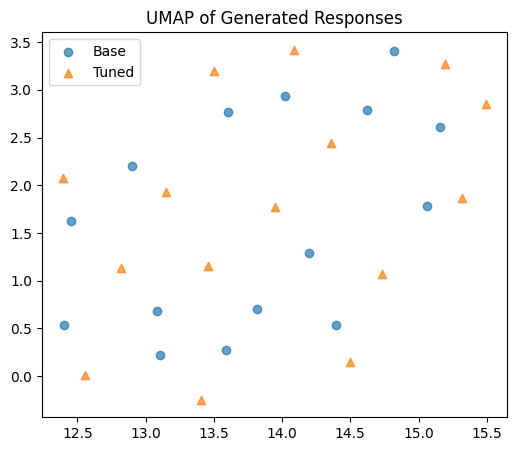

In [10]:
# 5-A  Project to 2-D
umap2d = umap.UMAP(n_neighbors=15, min_dist=0.1, metric="cosine", random_state=0)
coords  = umap2d.fit_transform(emb_all)

# 5-B  Plot
plt.figure(figsize=(6,5))
for lab, marker in [("Base", "o"), ("Tuned", "^")]:
    ix = [i for i,l in enumerate(labels) if l==lab]
    plt.scatter(coords[ix,0], coords[ix,1], marker=marker, label=lab, alpha=0.7)
plt.title("UMAP of Generated Responses")
plt.legend(); plt.show()


In [11]:
pd.set_option("display.max_colwidth", None)     # show full text
display(df.head(5)[["question", "base", "tuned"]])


,question,base,tuned
0,请帮我看看我的家庭运势。,当然可以！不过请注意，我无法提供具体的占卜或算命服务，但可以给你一些关于家庭运势的建议和思考方向。\n\n1. **沟通**：家庭成员之间的沟通非常重要。保持开放的对话，倾听彼此的想法和感受，可以增进理解和和谐。\n\n2. **和谐**：努力营造一个和谐的家庭氛围，定期进行家庭活动，增进感情。\n\n3. **财务管理**：关注家庭的财务状况，合理规划开支和储蓄，避免不必要的经济压力。\n\n4. **健康**：家庭成员的健康是幸福的基础，关注饮食、锻炼和心理健康，保持良好的生活习惯。\n\n5. **支持与理解**：在家庭中，互相支持和理解是非常重要的，尤其是在面对困难时。\n\n如果你有具体的情况或问题，欢迎分享，我可以提供更有针对性的建议！,关于家庭运势的分析通常涉及多个方面，包括家庭关系、财务状况、健康状况和整体和谐度等。以下是一些通用建议，供你参考：\n\n### 1. 家庭关系\n- **沟通**：保持开放的沟通渠道，定期进行家庭会议，讨论每个人的需求和期望。\n- **包容**：尊重每个家庭成员的个性差异，避免过度干预他人的生活选择。\n\n### 2. 财务状况\n- **预算管理**：制定家庭年度预算，合理分配教育、医疗、住房等支出。\n- **储蓄计划**：建立应急基金，建议储备3-6个月的生活费用。\n\n### 3. 健康状况\n- **定期体检**：为每位家庭成员安排年度健康检查，尤其关注中老年人的慢性病管理。\n- **健康饮食**：共同制定健康饮食计划，减少外食频率，增加蔬菜水果摄入。\n\n### 4. 和谐度提升\n- **共同活动**：每月至少安排一次家庭团建活动，如短途旅行、户外野餐或家庭游戏夜。\n- **节日仪式**：重视传统节日的庆祝，增强家庭凝聚力。\n\n### 5. 注意事项\n- **冲突管理**：遇到矛盾时，优先冷静处理，避免情绪化争吵。可以尝试“轮流发言”制，让每个人都有表达机会。\n- **外部支持**：必要时寻求专业家庭咨询师的帮助，特别是在重大变故（如离婚、失业）后。\n\n家庭运势的改善往往需要全体成员的共同努力，保持耐心和信心，逐步建立积极的家庭生态。
1,属蛇的人今年适合结婚吗？,根据中国传统的生肖文化，属蛇的人在2023年的运势会受到多种因素的影响，包括个人的八字、流年运势等。一般来说，属蛇的人在选择结婚的时机时，可以考虑以下几点：\n\n1. **个人感情状况**：如果感情稳定，双方都有结婚的意愿和准备，那么无论年份如何，都是适合结婚的时机。\n\n2. **流年运势**：2023年是兔年，属蛇的人在这一年可能会面临一些挑战，但也有机会。可以参考一些专业的命理师的建议，看看是否适合在这一年结婚。\n\n3. **家庭和社会因素**：结婚不仅是两个人的事情，还涉及到家庭和社会的因素。如果双方家庭都支持，且有良好的社会环境，那么结婚的时机就更为合适。\n\n总的来说，属蛇的人在2023年是否适合结婚，主要还是要看个人的具体情况和感情基础。如果有疑虑，可以咨询专业的命理师或婚姻顾问。,根据中国传统生肖文化，2023年癸卯兔年对于属蛇人的婚姻运势有以下几点参考：\n\n1. **三合生肖**：兔与蛇为三合关系，属蛇人在兔年容易遇到良缘，适合把握机遇。若已有稳定关系，可考虑结婚。\n\n2. **红鸾星动**：流年红鸾星照，单身者易遇正缘，已婚者感情升温，结婚有利于巩固关系。\n\n3. **注意冲突**：需避免与属猪、猴者发生矛盾，婚礼安排需协调双方家庭意见。\n\n4. **择吉为宜**：建议选择农历三月、六月、十月等吉月，避开本命年冲太岁月份。\n\n5. **现代视角**：婚姻成功与否更依赖双方沟通、价值观契合，生肖仅为参考。\n\n总之，属蛇人在兔年结婚有利有机，但需结合个人实际情况谨慎决策。
2,想请问一下结婚的良辰吉日该如何选择？,选择结婚的良辰吉日可以考虑以下几个方面：\n\n1. **黄历查询**：可以参考农历黄历，选择那些标注为“结婚吉日”的日期。黄历通常会提供适合结婚的日子，并标明适合的活动。\n\n2. **生肖相合**：根据新郎新娘的生肖，选择相合的日子。比如，某些生肖在特定年份或月份会有更好的运势。\n\n3. **五行相生**：根据新郎新娘的生辰八字，分析五行的缺失与相生关系，选择能够补充五行的日子。\n\n4. **避开忌日**：避免选择双方的忌日或不吉利的日子，比如个人的生日、丧亲的忌日等。\n\n5. **家庭意见**：可以征求双方家庭的意见，尊重长辈的看法，选择一个大家都能接受的日子。\n\n6. **个人喜好**：选择一个对双方有特别意义的日子，比如第一次约会的纪念日等。\n\n7. **专业咨询**：如果条件允许，可以请教专业的命理师或风水师，帮助选择一个更合适的日子。\n\n总之，选择结婚的良辰吉日是一个综合考虑的过程，既要尊重传统，也要结合个人的实际情况。希望你们能找到一个合适的日子，祝福你们幸福美满！,选择结婚良辰吉日时，通常结合传统文化习俗与现代生活方式，以下是一些常见的参考原则：\n\n### 1. **传统择日原则**\n- **避开冲日**：根据新人的生肖，避开与双方生肖相冲的日子（如鼠与马、牛与羊等）。\n- **选择喜日**：优先选择「天德」、「月德」、「三合」等吉星照临的日子。\n- **农历节气**：立春、夏至、秋分、冬至等节气前后被视为吉时。\n- **避开特殊日子**：如丧期、重大祭祀日、家族成员忌日等。\n\n### 2. **现代实用考量**\n- **季节气候**：根据当地气候选择适宜的季节（如避开梅雨季、极寒冬季）。\n- **假期安排**：结合双方家庭、亲友的假期，方便邀请亲友参加。\n- **婚礼场地**：提前确认婚礼场地的可用性，热门日期可能需提前预定。\n\n### 3. **个性化调整**\n- **双方家庭习俗**：尊重双方家庭的传统习惯（如某一方家族的特殊忌讳）。\n- **个人偏好**：选择对新人有特殊意义的日期（如初次约会日、求婚日等）。\n\n### 4. **现代科技辅助**\n- **择日软件/APP**：市面上有许多结合传统历法与现代算法的择日工具，可提供参考。\n- **专业择日师**：若条件允许，可咨询专业的命理师进行个性化择日。\n\n### 5. **灵活应对**\n- **双重选择**：准备两个备选日期，以应对突发情况（如天气、场地变动）。\n- **简化流程**：现代婚礼越来越多元化，重要的是仪式的意义，过于拘泥于传统可能增加压力。\n\n### 小贴士\n- 提前3-6个月开始择日，热门婚礼季节的场地和服务资源会更紧张。\n- 选择日期后，尽早通知亲友，特别是需要远道而来的亲属。\n\n最终，良辰吉日的核心在于「合家欢庆、心意相通」，无论选择何时，重要的是新人共同的幸福愿景。
3,请大师指点，1985年出生的我今年适合转行吗？,转行的决定通常取决于多个因素，包括个人的兴趣、职业发展前景、经济状况以及自身的技能和经验。1985年出生的你在2023年已经38岁，正处于职业发展的一个重要阶段。以下是一些建议，帮助你判断是否适合转行：\n\n1. **兴趣与热情**：首先，考虑你对新行业的兴趣和热情。转行通常需要时间和精力的投入，如果你对新领域充满热情，转行的动力会更强。\n\n2. **技能与经验**：评估你现有的技能和经验是否可以转移到新行业。许多技能在不同领域之间是可以迁移的，比如沟通能力、项目管理等。\n\n3. **市场需求**：研究你感兴趣的新行业的市场需求和发展前景。了解该行业的趋势、薪资水平以及职业发展路径，可以帮助你做出更明智的决定。\n\n4. **经济状况**：考虑当前的经济状况和你个人的财务状况。转行可能会带来短期的经济压力，因此确保你有足够的财务支持来应对这一变化。\n\n5. **学习与培训**：如果你决定转行，可能需要进行额外的学习或培训。考虑你是否愿意投入时间和资源来提升相关技能。\n\n6. **网络与资源**：利用你的人际网络，了解你感兴趣的行业。与在该行业工作的人交流，获取第一手的信息和建议。\n\n总之，转行是一个重要的决定，建议你仔细考虑上述因素，并根据自己的情况做出选择。如果你对新领域充满信心，并且做好了充分的准备，转行可能会为你带来新的机遇和挑战。,"根据您的出生年份（1985年），2023年您38岁。从命理角度看，38岁正处于人生的""中年转折期""，此时转行需综合考虑以下几点：\n\n1. **大运流年**：1985年属牛，2023年为癸卯兔年。兔年与牛年三合，流年运势较顺，适合尝试新方向，但需注意卯木克土，建议选择与土相关行业（如房地产、农业、教育）或木相关行业（如文化、设计、环保）。\n\n2. **八字喜用**：若八字喜水、金，2023年流年水旺（癸水），可把握机遇；若喜火、土，则需谨慎，避免过度冒险。\n\n3. **职业规划**：\n - **优势行业**：教育培训、咨询顾问、项目管理、跨境电商等\n - **技能提升**：建议考取行业认证（如PMP、CMA等），增强竞争力\n - **人脉拓展**：多参加行业交流会，建立新领域的人脉资源\n\n4. **转行策略**：\n - **试水期**：可先兼职或做项目试水，避免全职转行带来的经济压力\n - **资金准备**：建议储备6个月生活费作为缓冲\n - **心理建设**：转行初期可能面临技能瓶颈，